# 0 Imports

In [1]:
import os, warnings
import shutil
from collections import namedtuple
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scripts import read_saves, write_saves, record_saves

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

print("-----------------------------------------")
if tf.test.gpu_device_name():
    print(f"GPU used: {tf.test.gpu_device_name()}")
else:
    print(f"GPU not used")
print("-----------------------------------------")

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

-----------------------------------------
GPU used: /device:GPU:0
-----------------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10707564443603449103
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3455778816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 159034187741624312
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-01-28 16:08:59.511969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-28 16:08:59.525650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 16:08:59.554592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 16:08:59.554781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

***
# 1 Config

In [2]:
config = {
    "exploration": False,
    "custom": True,
    "transfer": False
}

In [3]:
annotations_dir = "data/Annotations"
images_dir = "data/Images"
target_dir = "data/Targets"
batch_size = 16

SAVE_PATH = "data/saves.pkl"
SAVE_NB = 5

***
# 2 Dataset exploration

## 2.0 Utils

In [4]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [5]:
def breeds_distribution(dataset, figsize=(25, 5), display_mean=True):
    plt.figure(figsize=figsize)

    sns.barplot(x=fre_df["Breed"], y=fre_df["Population"])

    if display_mean:
        mean = fre_df.mean(axis=0)[0]
        plt.axhline(mean, linestyle="--", linewidth=1, color="r")

    plt.title("Breeds distribution", size=20)
    plt.xticks(size=10, rotation=45, ha="right")
    plt.yticks(size=10)
    plt.ylabel("Count", size=16)

    if display_mean:
        return mean

***
## 2.1 Breeds distribution

How many breeds are present in the dataset ?

In [6]:
breed_subdir = os.listdir(images_dir)
print(f"There is {len(breed_subdir)} different dog breeds")

There is 120 different dog breeds


Construct a pandas dataset with all breeds and each of their respective population

In [7]:
breed_full: list = []
breed: list = []
population: list = []

for sub_d in breed_subdir:
    breed_full.append(sub_d)
    breed.append(sub_d.split("-")[1])
    population.append(len([obs for obs in os.listdir(images_dir + "/" + sub_d)]))

fre_df = pd.DataFrame(data={"Breed_full": breed_full, "Breed": breed, "Population": population})
fre_df.head()

,Breed_full,Breed,Population
0,n02111889-Samoyed,Samoyed,218
1,n02105641-Old_English_sheepdog,Old_English_sheepdog,169
2,n02107908-Appenzeller,Appenzeller,151
3,n02100583-vizsla,vizsla,154
4,n02097298-Scotch_terrier,Scotch_terrier,158


Plot the breeds populations and the mean

In [8]:
if config["exploration"]:
    mean = breeds_distribution(fre_df)

Let's plot again bu after a sort on Population field

In [9]:
if config["exploration"]:
    fre_df.sort_values(by="Population", inplace=True, ascending=False, axis=0)
    mean = breeds_distribution(fre_df)

Let's take a look at the top three breeds, see if they are sufficiently differents.

In [10]:
if config["exploration"]:

    fix, axs = plt.subplots(3, 3, figsize=(20, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Malteses
    plt.subplot(3, 3, 1)
    image = tf.io.read_file("data/Images/n02085936-Maltese_dog/n02085936_37.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 2)
    image = tf.io.read_file("data/Images/n02085936-Maltese_dog/n02085936_66.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 3)
    image = tf.io.read_file("data/Images/n02085936-Maltese_dog/n02085936_233.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    # Afghan
    plt.subplot(3, 3, 4)
    image = tf.io.read_file("data/Images/n02088094-Afghan_hound/n02088094_231.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 5)
    image = tf.io.read_file("data/Images/n02088094-Afghan_hound/n02088094_251.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 6)
    image = tf.io.read_file("data/Images/n02088094-Afghan_hound/n02088094_272.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    # Scottish deerhound
    plt.subplot(3, 3, 7)
    image = tf.io.read_file("data/Images/n02092002-Scottish_deerhound/n02092002_3.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 8)
    image = tf.io.read_file("data/Images/n02092002-Scottish_deerhound/n02092002_198.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3, 3, 9)
    image = tf.io.read_file("data/Images/n02092002-Scottish_deerhound/n02092002_86.jpg")
    image = tf.io.decode_jpeg(image, channels=3)
    img = tf.squeeze(image).numpy()
    plt.imshow(img)
    plt.axis('off')

We can see that the images don't have the same size

In [11]:
fre_df = fre_df.iloc[:10,:]
fre_df

,Breed_full,Breed,Population
0,n02111889-Samoyed,Samoyed,218
1,n02105641-Old_English_sheepdog,Old_English_sheepdog,169
2,n02107908-Appenzeller,Appenzeller,151
3,n02100583-vizsla,vizsla,154
4,n02097298-Scotch_terrier,Scotch_terrier,158
5,n02109525-Saint_Bernard,Saint_Bernard,170
6,n02088466-bloodhound,bloodhound,187
7,n02094433-Yorkshire_terrier,Yorkshire_terrier,164
8,n02086079-Pekinese,Pekinese,149
9,n02097130-giant_schnauzer,giant_schnauzer,157


***
# 3 Custom CNN

## 3.0 Utils

In [12]:
def sync_dataset_directory(breeds: list, source_dir: str = "data/Images", target_dir: str = "data/Targets"):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.mkdir(target_dir)
    for breed in breeds:
        source = source_dir + "/" + breed
        target = target_dir + "/" + breed
        shutil.copytree(source, target)

In [25]:
def visualize_history(history, figsize=(20, 10), metrics: str = "categorical_accuracy"):
    fix, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)

    plt.subplot(2, 1, 1)
    plt.title("Loss")
    sns.lineplot(data=history, x=history.index, y="loss", label="loss")
    sns.lineplot(data=history, x=history.index, y="val_loss", label="val_loss")
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    sns.lineplot(data=history, x=history.index, y=metrics, label=metrics)
    sns.lineplot(data=history, x=history.index, y="val_" + metrics, label="val_" + metrics)
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

***
## 3.1 Dataset preparation

In [14]:
if config["custom"]:

    sync_dataset_directory(fre_df["Breed_full"])

    ds_train_ = image_dataset_from_directory(
        target_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=[224, 224],
        interpolation="nearest",
        batch_size=batch_size,
        seed=0,
        shuffle=True,
        validation_split=0.8,
        subset="training"
    )

    ds_valid_ = image_dataset_from_directory(
        target_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=[224, 224],
        interpolation="nearest",
        batch_size=batch_size,
        seed=0,
        shuffle=True,
        validation_split=0.2,
        subset="validation"
    )

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

Found 1677 files belonging to 10 classes.
Using 336 files for training.
Found 1677 files belonging to 10 classes.
Using 335 files for validation.


2022-01-28 16:09:00.633101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 16:09:00.633327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 16:09:00.633458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 16:09:00.634186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 16:09:00.634388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

***
## 3.2 Neural Network

In [15]:
if config["custom"]:

    model = keras.Sequential([
        # >>> preprocessing <<<

        # >>> base <<<
        layers.BatchNormalization(
            input_shape=[224, 224, 3],
        ),

        layers.Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu"
            ),
        layers.MaxPool2D(
            pool_size=3,
            strides=3,
            padding="valid"
        ),

        layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            ),
        layers.MaxPool2D(
            pool_size=3,
            strides=3,
            padding="valid"
        ),

        # layers.Conv2D(
        #     filters=128,
        #     kernel_size=3,
        #     strides=1,
        #     padding="same",
        #     activation="relu",
        #     ),
        # layers.Conv2D(
        #     filters=128,
        #     kernel_size=3,
        #     strides=1,
        #     padding="same",
        #     activation="relu",
        #     ),
        # layers.MaxPool2D(
        #     pool_size=3,
        #     strides=3,
        #     padding="valid"
        # ),

        # >>> head <<<
        layers.Flatten(),

        layers.Dropout(rate=0.3),
        layers.BatchNormalization(),
        layers.Dense(units=64, activation="relu"),

        layers.Dense(units=fre_df.shape[0], activation="softmax")
    ])

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                        

In [16]:
if config["custom"]:
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    early_stopping = EarlyStopping(
        min_delta=0.001,
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=20,
        # callbacks=[early_stopping]
        # verbose=0
    )

Epoch 1/20


2022-01-28 16:09:02.542499: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300


21/21 [==============================] - 4s 72ms/step - loss: 3.7825 - categorical_accuracy: 0.1815 - val_loss: 2.3183 - val_categorical_accuracy: 0.1373
Epoch 2/20
21/21 [==============================] - 1s 52ms/step - loss: 1.0645 - categorical_accuracy: 0.6935 - val_loss: 2.3775 - val_categorical_accuracy: 0.1075
Epoch 3/20
21/21 [==============================] - 1s 52ms/step - loss: 0.3420 - categorical_accuracy: 0.8958 - val_loss: 2.6757 - val_categorical_accuracy: 0.0687
Epoch 4/20
21/21 [==============================] - 1s 52ms/step - loss: 0.1450 - categorical_accuracy: 0.9613 - val_loss: 2.7839 - val_categorical_accuracy: 0.1134
Epoch 5/20
21/21 [==============================] - 1s 53ms/step - loss: 0.0264 - categorical_accuracy: 0.9940 - val_loss: 2.7655 - val_categorical_accuracy: 0.1403
Epoch 6/20
21/21 [==============================] - 1s 52ms/step - loss: 0.0092 - categorical_accuracy: 1.0000 - val_loss: 2.8682 - val_categorical_accuracy: 0.1522
Epoch 7/20
21/21 [===

***
## 3.3 Results

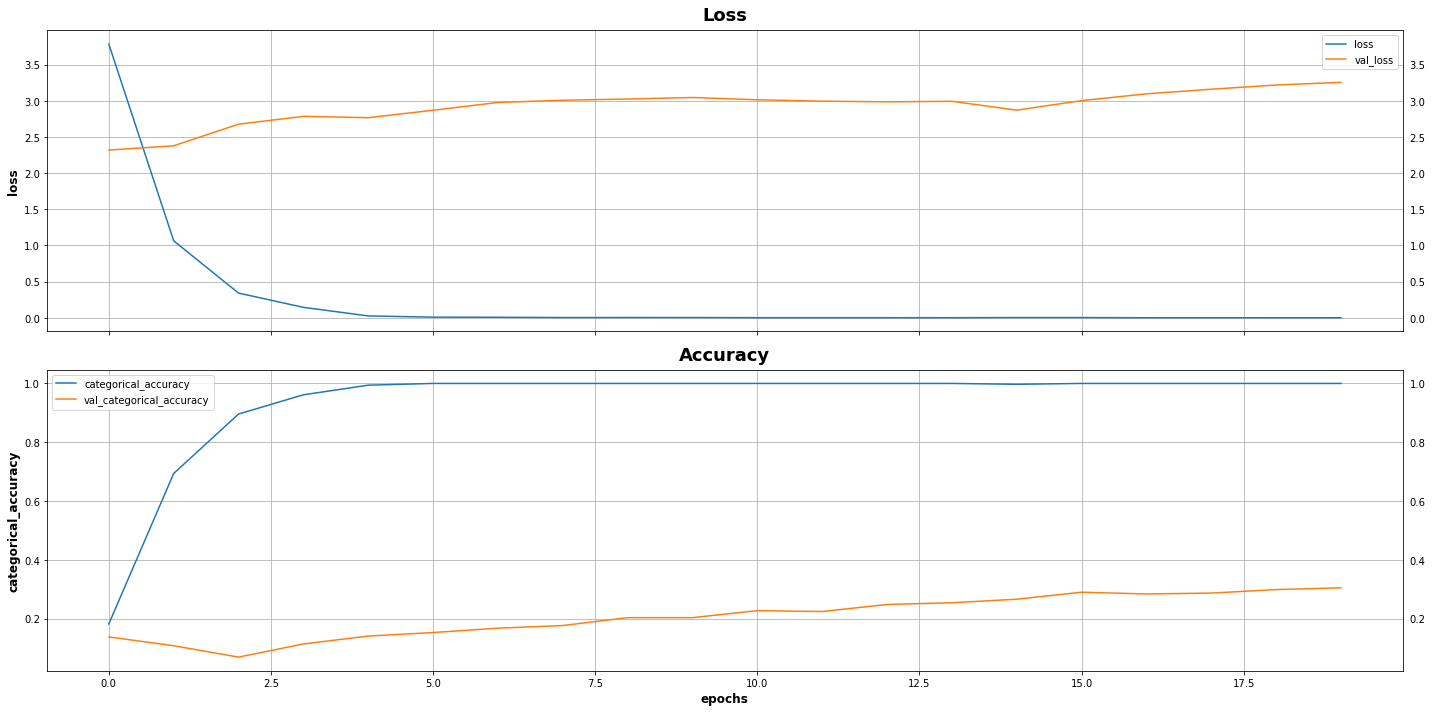

In [26]:
history_df = pd.DataFrame(data=history.history)
visualize_history(history_df)

In [18]:
# saves = record_saves(SAVE_PATH, SAVE_NB, history, model)

In [19]:
# for i, (key, (model_json, history)) in enumerate(saves.items()):
#     if i == 0:
#         visualize_history(history)
#     else:
#         visualize_history(history, figsize=(10, 6))
#         # json_parsed = json.loads(model_json)
#         # print(json.dumps(json_parsed, indent=4, sort_keys=True))

In [20]:
# tab_contents = saves.keys()
# children = []

# for i, (key, (model_json, history)) in enumerate(saves.items()):
#     if i == 0:
#         visualize_history(history)
#     else:
#         out = widgets.Output()
#         children.append(out)
#         with out:
#             visualize_history(history, figsize=(10, 6))
#             json_parsed = json.loads(model_json)
#             print(json.dumps(json_parsed, indent=4, sort_keys=True))

# tab = widgets.Tab(children=children)
# for i, child in enumerate(children):
#     tab.set_title(i, "tab"+str(i))

# display(tab)

***
# 4 Transfer learning CNN

In [21]:
if config["transfer"]:

    pass